# Import libraries

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import itertools as it
import copy

# Train, test, verification split

In [2]:
def train_test_verification_split(X, y, split_tr, split_v, split_te):    
    # define the data split
    total_count = X.shape[0]
    split = int(total_count * split_tr)
    return X[:split], y[:split], X[split:], y[split:]

# Read the data

### Run this for the toy problem

In [ ]:
toy_problem = True
print("Using the toy problem...")
f = lambda x: np.sin(0.9*x)
#f = lambda x: np.exp(x)
#f = lambda x: 2*x+4

X_data = np.linspace(-5,5,100).reshape(-1,1)
y_data = f(X_data)

df = pd.DataFrame(np.c_[X_data, y_data])
# shuffle data
df = df.sample(frac=1).reset_index(drop=True)

# split off the target variable
X, y = df.iloc[:,:-1], df.iloc[:,-1]
# normalise data
X = (X - X.min()) / (X.max() - X.min())

print("Splitting data...")
X_train, y_train, X_test, y_test = train_test_verification_split(X, y, 0.6, 0.2, 0.2)

plt.plot(X, y, "r+")
plt.xlabel("Independent variable X")
plt.ylabel("Target variable y")
plt.show()

### Run this for the SARCOS dataset

In [3]:
toy_problem = False
print("Using the SARCOS dataset...")
# read in csv file
df = pd.read_csv("sarcos_inv.csv", header=None)
# shuffle data
df = df.sample(frac=1).reset_index(drop=True)

# split off the target variable
X, y = df.iloc[:,:-1], df.iloc[:,-1]
# normalise data
X = (X - X.min()) / (X.max() - X.min())

print("Splitting data...")
X_train, y_train, X_test, y_test = train_test_verification_split(X, y, 0.6, 0.2, 0.2)

Using the SARCOS dataset...
Splitting data...


# Utility class

This function computes the root mean squared error, given the actual data and the predicted data of the target variable.

In [4]:
class util():
    @staticmethod
    def score(actual, prediction):
        return math.sqrt(np.mean((actual - prediction)**2))
    
    @staticmethod
    def squared_error(actual, prediction):
        return np.sum((actual - prediction)**2)
    
    @staticmethod
    def mean_absolute_error(actual, prediction):
        return np.sum(np.fabs(actual - prediction)) / actual.shape[0]

# K Nearest Neighbours regression

This is my implementation of K Nearest Neighbours regression.

In [5]:
class k_nearest_neighbours():
    
    def __init__(self, k):
        self.k = k
        
    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train
    
    def predict(self, X):
        # compute distance matrix
        distances_sq = np.einsum('ij, ij ->i', X, X)[:, None] +\
                    np.einsum('ij, ij ->i', self.X_train, self.X_train) -\
                    2 * X.dot(self.X_train.T)
    
        # calculate the mean of the k neighbours - the prediction
        y_pred = np.mean(self.y_train[np.argsort(distances_sq)[:,:self.k]], axis=1)
        
        #return the prediction
        return y_pred

In [6]:
def perform_knn(k, X_tr, y_tr, X_, y_):    
    # train
    knn_regressor = k_nearest_neighbours(k)
    knn_regressor.fit(X_tr.values, y_tr.values)
    
    # predict
    y_pred = knn_regressor.predict(X_.values)

    # compute rmse
    rmse = util.score(y_.values.flatten(), y_pred.flatten())
    print("The RMSE for k={} is {}".format(k, rmse))  
    
    return rmse, y_pred

In [7]:
def cross_validate(data, k):
    lists = np.split(data, 5)
    rmse_arr = []
    for test_set in lists:
        X_test = pd.DataFrame(test_set[:,:-1])
        y_test = pd.DataFrame(test_set[:,-1])
        train_set = []
        
        for i in lists:
            if not np.all(np.isclose(test_set, i)):
                train_set.append(i)
        
        train_set1 = np.asarray(train_set)
        train_set2 = train_set1.reshape(train_set1.shape[0]*train_set1.shape[1], train_set1.shape[2])

        X_tr = pd.DataFrame(train_set2[:,:-1])
        y_tr = pd.DataFrame(train_set2[:,-1])
          
        rmse, _, = perform_knn(k, X_tr, y_tr, X_test, y_test)
        rmse_arr.append(rmse)
    return np.mean(rmse_arr)   

##### The cells below are used to tune the hyperparameters using the verification set

In [8]:
# find the best k using the verfication set
def get_best_k(max_k):
    rmse_arr = []
    for k in range(1, max_k+1):
        rmse = cross_validate(np.c_[X_train, y_train], k)
        rmse_arr.append(rmse)
    return np.argmin(rmse_arr)+1, rmse_arr

In [9]:
print("This will take a couple minutes...")
print("Finding the best k value using cross validation...")
# tune the hyperparameter with the verification set
max_k = 10
best_k, rmse_arr = get_best_k(max_k)

This will take a couple minutes...
Finding the best k value using cross validation...
The RMSE for k=1 is 4.793069436600454
The RMSE for k=1 is 4.728626232379359
The RMSE for k=1 is 4.860350897137897
The RMSE for k=1 is 4.793870787356438
The RMSE for k=1 is 4.753509684885847
The RMSE for k=2 is 4.059656326556451
The RMSE for k=2 is 4.159556947373653
The RMSE for k=2 is 4.074604921322737
The RMSE for k=2 is 4.224546575038194
The RMSE for k=2 is 3.9168984633276707
The RMSE for k=3 is 4.041491577486768
The RMSE for k=3 is 4.157641150317737
The RMSE for k=3 is 4.079018291799268
The RMSE for k=3 is 4.129885196154053
The RMSE for k=3 is 3.9272248467879014
The RMSE for k=4 is 4.087654454493418
The RMSE for k=4 is 4.185591164449055
The RMSE for k=4 is 4.105706643426289
The RMSE for k=4 is 4.175787436830977
The RMSE for k=4 is 4.068762443458335
The RMSE for k=5 is 4.214973850008755
The RMSE for k=5 is 4.299376311862975
The RMSE for k=5 is 4.219833312288062
The RMSE for k=5 is 4.288465869706311


#### The cell below is for using the trained model to predict with the test set

In [10]:
print("\nPerforming the trained model on the test set with the best k, k={}...".format(best_k))
rmse_test, y_pred = perform_knn(best_k, X_train, y_train, X_test, y_test)


Performing the trained model on the test set with the best k, k=3...
The RMSE for k=3 is 3.7452267653670086


#### Plot the 'elbow curve' to show the best K value

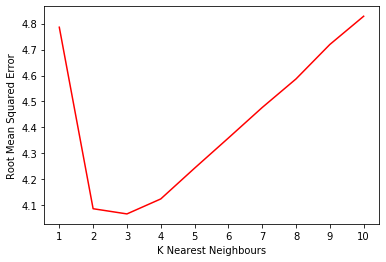

In [11]:
plt.plot(np.arange(1,max_k+1), rmse_arr, "r-")
plt.xticks(np.arange(1,max_k+1))
plt.xlabel("K Nearest Neighbours")
plt.ylabel("Root Mean Squared Error")
plt.show()

### Plot to check that KNN works for the toy problem

In [ ]:
if toy_problem:
    plt.plot(X_test, y_test, "r+")
    plt.title("Actual data")
    plt.xlabel("Independent variable X")
    plt.ylabel("Target variable y")
    plt.show()

    plt.plot(X_test, y_pred, "r+")
    plt.title("Predicted data")
    plt.xlabel("Independent variable X")
    plt.ylabel("Target variable y")
    plt.show()

    plt.plot(np.sort(X_test.values.flatten()), y_test.values[np.argsort(X_test.values.flatten())], "b-", label="actual data")
    plt.plot(X_test, y_pred, "r+", markersize=20, label="predicted data")
    plt.title("Comparison between actual and predicted data")
    plt.xlabel("Feature variable X")
    plt.ylabel("Target variable y")
    plt.legend()
    plt.show()